In [ ]:
# Importation des librairies
from webscraping.ws_fonctions import *
import seaborn as sns
import matplotlib.pyplot as plt


# Regression
import statsmodels.api as sm
from statsmodels.formula.api import rlm # => pour regression robuste à hétéroscédasticité


In [104]:
# Récupération par webscrapping des données 
data = get_comparaison_notes(2021, 30)
data.head()

,date,durée,spectateur,presse,genre1,genre2,genre3
0,22 septembre 2021,1h 49min,"3,5","3,4",Comédie,Comédie dramatique,Drame
1,15 septembre 2021,2h 36min,"4,2","4,0",Drame,Science Fiction,
2,16 mars 2022,1h 27min,"2,1","1,8",Comédie,,
3,1 septembre 2021,1h 47min,"3,8","3,8",Comédie dramatique,,
4,1 septembre 2021,1h 51min,"2,8","2,8",Epouvante-horreur,Thriller,


## Nettoyage des données et création de colonnes

In [112]:
# Transformation des types de films en variables dummy 
dummies1 = pd.get_dummies(data['genre1'], prefix='genre')
dummies2 = pd.get_dummies(data['genre2'], prefix='genre')
dummies3 = pd.get_dummies(data['genre3'], prefix='genre')

dummies1 = dummies1.astype(int)
dummies2 = dummies2.astype(int)
dummies3 = dummies3.astype(int)

dummies_sum = dummies1.add(dummies2, fill_value=0).add(dummies3, fill_value=0)
dummies_sum = dummies_sum.drop(columns=['genre_'])

df = pd.concat([data, dummies_sum], axis=1)
print('nombre de films pris en compte :', len(df))

nombre de films pris en compte : 296


In [113]:
# Conversion durée en minutes
def duree_en_minutes(duree):
    ''' 
    Conversion en minutes
    
    ENTREE :
    - duree : chaine de caractère de la forme '2h 34min'

    SORTIE : 
    - Retourne la conversion en minutes de 'duree'

    '''
    parts = duree.split()

    heures = 0
    minutes = 0

    for part in parts:
        if 'h' in part:
            heures = int(part.replace('h', ''))
        elif 'min' in part:
            minutes = int(part.replace('min', ''))

    return heures * 60 + minutes


def conversion_decimale(valeur):

    return float(valeur.replace(',', '.'))


df['spectateur'] = df['spectateur'].apply(conversion_decimale)
df['presse'] = df['presse'].apply(conversion_decimale)


df['duree_min'] = df['durée'].apply(duree_en_minutes)


# Création variable : différence de notation entre spectateur et presse
df['diff_notation'] = df['spectateur']-df['presse']
df.head()


,date,durée,spectateur,presse,genre1,genre2,genre3,genre_Action,genre_Animation,genre_Arts Martiaux,...,genre_Judiciaire,genre_Musical,genre_Policier,genre_Romance,genre_Science Fiction,genre_Thriller,genre_Western,genre_Évènement Sportif,duree_min,diff_notation
0,22 septembre 2021,1h 49min,3.5,3.4,Comédie,Comédie dramatique,Drame,0.0,0.0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0.0,109,0.1
1,15 septembre 2021,2h 36min,4.2,4.0,Drame,Science Fiction,,0.0,0.0,0.0,...,0.0,0.0,0,0,1.0,0,0.0,0.0,156,0.2
2,16 mars 2022,1h 27min,2.1,1.8,Comédie,,,0.0,0.0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0.0,87,0.3
3,1 septembre 2021,1h 47min,3.8,3.8,Comédie dramatique,,,0.0,0.0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0.0,107,0.0
4,1 septembre 2021,1h 51min,2.8,2.8,Epouvante-horreur,Thriller,,0.0,0.0,0.0,...,0.0,0.0,0,0,0.0,1,0.0,0.0,111,0.0


## Quelques graphes....

Text(0, 0.5, 'Fréquence')

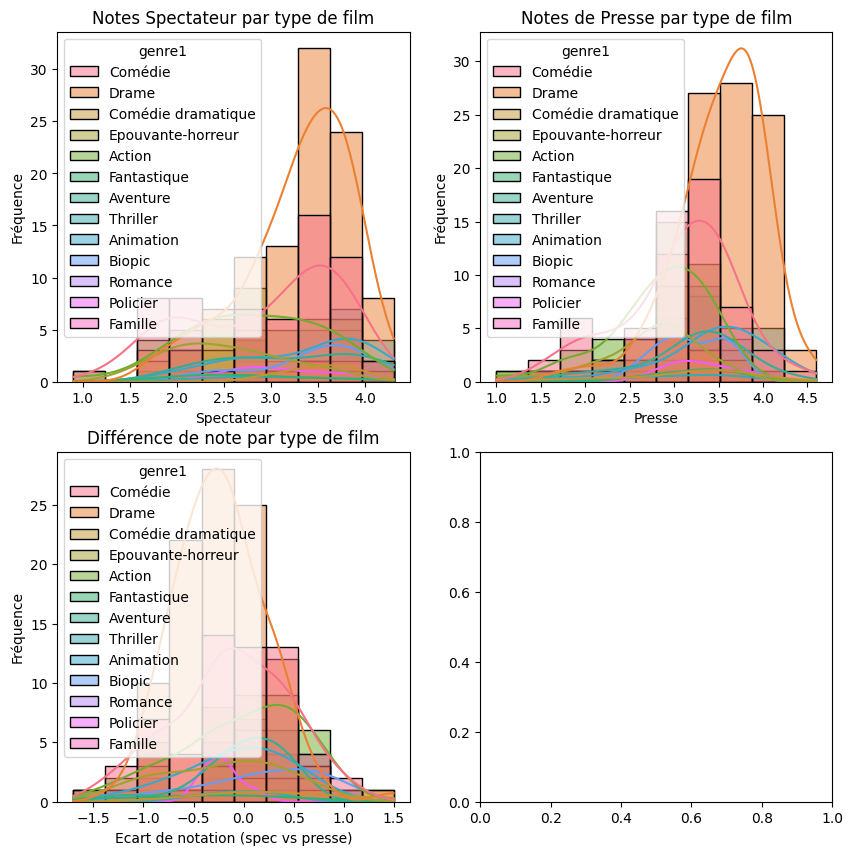

In [114]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Histogramme des notes SPECTATEUR par type de film
sns.histplot(data=df, x='spectateur', hue='genre1', bins=10, kde=True, ax=axes[0,0])
axes[0,0].set_title('Notes Spectateur par type de film')
axes[0,0].set_xlabel('Spectateur')
axes[0,0].set_ylabel('Fréquence')

# Histogramme des notes PRESSE par du type de film
sns.histplot(data=df, x='presse', hue='genre1', bins=10, kde=True, ax=axes[0,1])
axes[0,1].set_title('Notes de Presse par type de film')
axes[0,1].set_xlabel('Presse')
axes[0,1].set_ylabel('Fréquence')


# Histogramme des DIFFERENCE de par type de film
sns.histplot(data=df, x='diff_notation', hue='genre1', bins=10, kde=True, ax=axes[1,0])
axes[1,0].set_title('Différence de note par type de film')
axes[1,0].set_xlabel('Ecart de notation (spec vs presse)')
axes[1,0].set_ylabel('Fréquence')


## Test de modèles sur la différence de notation

### ANOVA (sur premier genre)

### Regression

- Notes spectateurs

In [122]:
# Définir les variables dépendantes et indépendantes
X = df[['duree_min', 'genre_Action', 'genre_Animation', 'genre_Policier', 'genre_Thriller', 'genre_Science Fiction', 'genre_Drame', 'genre_Aventure']]
y = df['spectateur']
X = sm.add_constant(X)

# Régression linéaire OLS
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             spectateur   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     15.89
Date:                Sun, 03 Nov 2024   Prob (F-statistic):           2.22e-19
Time:                        19:22:41   Log-Likelihood:                -256.63
No. Observations:                 296   AIC:                             531.3
Df Residuals:                     287   BIC:                             564.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.71

- Notes presse

In [124]:
# Définir les variables dépendantes et indépendantes
X = df[['duree_min', 'genre_Action', 'genre_Animation', 'genre_Policier', 'genre_Thriller', 'genre_Science Fiction', 'genre_Drame', 'genre_Aventure']]
y = df['presse']
X = sm.add_constant(X)

# Régression linéaire OLS
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 presse   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     17.38
Date:                Sun, 03 Nov 2024   Prob (F-statistic):           4.49e-21
Time:                        19:23:34   Log-Likelihood:                -216.55
No. Observations:                 296   AIC:                             451.1
Df Residuals:                     287   BIC:                             484.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.29

- Différences de notations

In [125]:
# Définir les variables dépendantes et indépendantes
X = df[['duree_min', 'genre_Action', 'genre_Animation', 'genre_Policier', 'genre_Thriller', 'genre_Science Fiction', 'genre_Drame', 'genre_Aventure']]
y = df['diff_notation']
X = sm.add_constant(X)

# Régression linéaire OLS
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          diff_notation   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.929
Date:                Sun, 03 Nov 2024   Prob (F-statistic):             0.0556
Time:                        19:25:00   Log-Likelihood:                -226.63
No. Observations:                 296   AIC:                             471.3
Df Residuals:                     287   BIC:                             504.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.57

In [126]:
# test robuste à l'hétéroscédasticité ?
model = rlm("diff_notation ~ duree_min + genre_Action + genre_Animation+genre_Policier+genre_Fantastique+genre_Drame+genre_Aventure", data=df).fit()
print(model.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:          diff_notation   No. Observations:                  296
Model:                            RLM   Df Residuals:                      288
Method:                          IRLS   Df Model:                            7
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Nov 2024                                         
Time:                        19:25:14                                         
No. Iterations:                    16                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.5961      0.18